In [1]:
import sys
sys.path.append('../Scarp/')

from downstream import *
import warnings
warnings.filterwarnings("ignore")

## Prepare input h5ad file for SCARP 

In [2]:
root_file = './Raw data/GSE126074_AdBrainCortex_atac/GSE126074_AdBrainCortex_SNAREseq_chromatin.'
barcodes = pd.read_table(root_file+'barcodes.tsv', header=None)
peaks = pd.read_table(root_file+'peaks.tsv', header=None)
matrix = sc.read(root_file+'counts.mtx', header=None)

In [3]:
data = sc.AnnData(matrix.X.T)
data.var = pd.DataFrame(index=peaks[0].to_list())
data.obs = pd.DataFrame(index=barcodes[0].to_list())

In [4]:
filtered_cells = pd.read_csv('./Processed data/SNARE_Celltype.csv', index_col=0)

In [5]:
data = filter_cells(data, filtered_cells.index)
sc.pp.filter_cells(data, 1)
sc.pp.filter_genes(data, 1)

In [6]:
data.write('./Processed Data/AdBrainCortex.h5ad')

## Run SCARP to obtain cell embedding for better clustering cells

In [7]:
random_state = 1
beta = 5000
m = 1.5
merge_thre = 3000

In [8]:
data_name = 'AdBrainCortex'
print('\n=========== Data information: %s ===========' % data_name)
data = sc.read_h5ad('./Processed Data/' + data_name + '.h5ad')

Cells = data.obs.index
Cells_num, Peaks_num = data.X.shape
N = Cells_num + Peaks_num
print('Number of Peaks:', Peaks_num)
print('Number of Cells:', Cells_num)


=========== Data information: AdBrainCortex ===========
Number of Peaks: 243838
Number of Cells: 8055


In [9]:
t, diffusion_mat = SCARP(data=data,
                         m=m,
                         merge_thre=merge_thre,
                         beta=beta,
                         peak_loc=True)


%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Started (without parallel computing)%%%%%%%%%%%%%%%%%%%%%%%%%%
       ====================== Chr1: 18296 Peaks ========================
       ====================== Chr2: 19041 Peaks ========================
       ====================== Chr3: 13266 Peaks ========================
       ====================== Chr4: 15137 Peaks ========================
       ====================== Chr5: 15502 Peaks ========================
       ====================== Chr6: 14036 Peaks ========================
       ====================== Chr7: 12981 Peaks ========================
       ====================== Chr8: 12654 Peaks ========================
       ====================== Chr9: 13661 Peaks ========================
       ====================== Chr10: 12616 Peaks ========================
       ====================== Chr11: 14463 Peaks ========================
       ====================== Chr12: 11049 Peaks ========================
       ===============

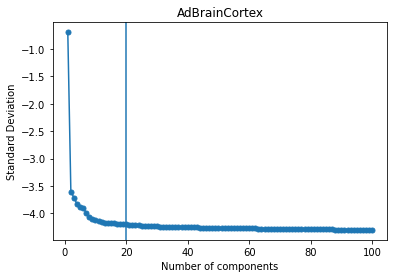

In [10]:
k = std_plot(data=diffusion_mat,
             title=data_name,
             max_k=100,
             plot_std=True,
             save_file='./Results/Kept component of ' + data_name + '.svg')

In [11]:
cell_mat = SCARP_cell_embedding(diffusion_mat=diffusion_mat,
                                kept_comp=k)
Cells_df = pd.DataFrame(cell_mat,
                        index=Cells,
                        columns=['Peaks' + str(i + 1) for i in range(cell_mat.shape[1])])
Cells_df.to_csv('./Results/SCARP_ATAC_Cells_df.txt')